In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import time as tm
import Sprayer_PDE as SP

import pypolo2

# Environment -- PINNS

In [2]:
Setting = pypolo2.utilities.Config()

env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model
Setting.env = env_model.solve(Setting.delta_t)


100%|██████████| 2.0/2.0 [00:00<00:00,  3.04it/s]    


In [3]:
# 确定存放地址
starttime = Setting.starttime.replace(' ', '-').replace(':', '-')
Savedir = '{}/{}/releaserate_{}'.format(Setting.root_dir,Setting.strategy_name,"%03d" %(Setting.delta_t*100))
Savename = 'seed{}'.format(Setting.seed)
Setting.save_dir = Savedir
Setting.save_name = Savename
evaluator = pypolo2.experiments.Evaluator()
logger = pypolo2.experiments.Logger(None, Setting)

# Sensor

In [4]:
sensor = pypolo2.sensors.Sprinkler(
    Setting = Setting
)

# Pilot Survey

In [5]:
rng = pypolo2.experiments.utilities.seed_everything(Setting = Setting)

Set random seed to 0 in random, numpy, and torch.


# Set initual data

In [6]:
# 初始化污染源
if Setting.randomsource == True:
    # gengerate two set of random numbers for source locations
    numbers = rng.randint(0, 19, size=Setting.sourcenum * 2)
    pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
    for i in range(Setting.sourcenum):
        number = rng.randint(150, 350, size=1)
        Setting.RR[i,0] = int(pairs[i,0])
        Setting.RR[i,1] = int(pairs[i,1])
        Setting.RR[i,2] = number

print(Setting.RR)
# #  每周期更新源信息,源是缓慢变化的，源会不断变强到顶峰，然后变弱。定义一个强度系数
s = 1
Setting.R =  -8 * np.ones((Setting.grid_x, Setting.grid_y)) + 16 * np.random.random((Setting.grid_x, Setting.grid_y))
for i in range(Setting.sourcenum):
        Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
        
# Setting.R[3][3] = 300
# Setting.R[17][17] = 300
# Setting.R[3][17] = 300
# Setting.R[17][3] = 300

env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model

y_init = np.zeros((Setting.num_init_samples,1))
y_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))
time_init = np.zeros((Setting.num_init_samples,1))
time_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))

#固定站的观测的观测
for time in range(Setting.time_before_sche):
    # y_stations[Setting.station_size*time:Setting.station_size*(time+1)] = sensor.sense(states=Setting.x_station, rng=rng).reshape(-1, 1)
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*Setting.time_co
    time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*1
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-10+1)*Setting.time_co
    Setting.env = env_model.solve((time+1)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
#假设每次观测后均变化时间，环境也随之发生变化
for time in range(Setting.num_init_samples):
    y_init[time] = sensor.sense(states=Setting.x_init[time], rng=rng).reshape(-1, 1)
    if time == 0:
        y_stations[:] = y_init[time] - 20
    # time_init[time] = (time+1)*Setting.time_co
    time_init[time] = (time+1)*1
    Setting.env = env_model.solve((1+Setting.time_before_sche+time)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
Setting.x_init = np.hstack((Setting.x_init,time_init))

Setting.x_stations = Setting.x_station
for i in range(Setting.time_before_sche-1):
    Setting.x_stations = np.vstack((Setting.x_stations,Setting.x_station))
Setting.x_stations = np.hstack((Setting.x_stations,time_stations))

Setting.x_init = np.vstack((Setting.x_stations,Setting.x_init))
y_init = np.vstack((y_stations,y_init))

[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  4.71it/s]    
100%|██████████| 4.0/4.0 [00:00<00:00, 13.89it/s]    
100%|██████████| 6.0/6.0 [00:00<00:00, 14.79it/s]    
100%|██████████| 8.0/8.0 [00:00<00:00, 15.04it/s]    
100%|██████████| 10.0/10.0 [00:00<00:00, 15.38it/s]   
100%|██████████| 12.0/12.0 [00:00<00:00, 15.54it/s]   


# Model

In [7]:
Setting.time_stamp = Setting.x_init[:,2].max(axis=0, keepdims=False)

In [8]:
kernel = pypolo2.kernels.RBF(Setting)

In [9]:
model = pypolo2.models.GPR(
    x_train=Setting.x_init,
    y_train=y_init,
    kernel=kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)

In [10]:
model.optimize(num_iter=model.num_train, verbose=True)

Iter: 05 loss:  8.64: 100%|██████████| 6/6 [00:00<00:00, 137.47it/s]


# Robot

In [11]:
vehicle_team = dict()
for i in range(Setting.team_size):
    robot = pypolo2.robots.SPRINKLER_REPLENISHANYWHERE(
        init_state = np.array([Setting.x_init[-1, 0], Setting.x_init[-1, 1]]),
        Setting = Setting
    )
    vehicle_team[i+1] = robot #因此team的id从1开始

# Strategy

In [12]:
strategy = pypolo2.strategies.SALatticePlanningSprinklerControl(
            task_extent=Setting.task_extent,
            rng=rng,
            vehicle_team=vehicle_team,
        )
Setting.strategy = strategy

# Experiment

In [13]:
#定义需要随时间更新的训练过程
def run(rng, model, Setting, sensor, evaluator, logger, vehicle_team) -> None:
    current_step = 0 #总规划长度
    adaptive_step = Setting.adaptive_step #自适应长度
    # change_step = Setting.R_change_interval - 0*Setting.adaptive_step # 污染源变化间隔
    change_step = 0
    spray_effect = 0 # 洒水效果
    result, MI_information, observed_env, computed_effect = None, None, None, None
    init_env = Setting.env
    tstart = 0
    while current_step < Setting.max_num_samples:
        # 计算用于洒水效果,环境真实值已知
        allpoint_list = []
        env_list = []
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                allpoint_list.append([i, j, model.time_stamp])
                env_list.append(Setting.env[i,j])
        allpoint = np.array(allpoint_list)
        env = np.array(env_list)
        mean, _ = model(allpoint)
        sprayeffect_all = pypolo2.objectives.sprayeffect.spray_effect(allpoint, allpoint, mean, Setting.task_extent).ravel()
        prior_diag_std, poste_diag_std, _, _ = model.prior_poste(allpoint)
        hprior = pypolo2.objectives.entropy.gaussian_entropy(prior_diag_std.ravel())
        hposterior = pypolo2.objectives.entropy.gaussian_entropy(poste_diag_std.ravel())
        mi_all = hprior - hposterior
        if np.any(mi_all < 0.0):
            print(mi_all.ravel())
            raise ValueError("Predictive MI < 0.0!")
        
        sprayeffect_all = pypolo2.objectives.sprayeffect.spray_effect(allpoint, allpoint, env, Setting.task_extent).ravel()
        MI_information = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        observed_env = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        computed_effect = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                MI_information[i,j] = mi_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                observed_env[i,j] = Setting.env[i,j]
                computed_effect[i,j] = sprayeffect_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                
        Setting.current_step = current_step
        # scheduling and update agent goals 计算搜索时间
        if adaptive_step >= Setting.adaptive_step:
            start = tm.time()
            result = Setting.strategy.get(model = model, Setting = Setting, pred = observed_env)
            adaptive_step = 0
            for id, vehicle in vehicle_team.items():
                vehicle.set_goals(result[id][0],result[id][1])
            end = tm.time()
            print('search_time')
            print(end-start)    
            
        # calculate metrix and save 
        coverage, mean_airpollution, max_airpollution = evaluator.eval_results(Setting.env, Setting.task_extent, vehicle_team)
        logger.append(current_step, Setting.env, observed_env, MI_information, computed_effect, vehicle_team, coverage, mean_airpollution, max_airpollution, spray_effect)
           
        # change source,每经过R_change_interval后，改变源分布和强度，
        if change_step >= Setting.R_change_interval:
            Setting.R =  -8 * np.ones((Setting.grid_x, Setting.grid_y)) + 16 * np.random.random((Setting.grid_x, Setting.grid_y))
            change_step = 0
            if Setting.randomsource == True:
                # gengerate two set of random numbers for source locations
                numbers = rng.randint(0, 4, size=Setting.sourcenum * 2)
                pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
                for i in range(Setting.sourcenum):
                    number = rng.randint(150, 350, size=1)
                    if Setting.RR[i,0]+pairs[i,0]-2 < Setting.grid_x-1 and Setting.RR[i,0] + pairs[i,0] - 2 >=0:
                        Setting.RR[i,0] = int(Setting.RR[i,0]+pairs[i,0]-2)
                    if Setting.RR[i,1]+pairs[i,1]-2 < Setting.grid_y-1 and Setting.RR[i,1] + pairs[i,1] - 2 >=0:
                        Setting.RR[i,1] = int(Setting.RR[i,1]+pairs[i,1]-2)
                    Setting.RR[i,2] = number
                init_env = Setting.env
                tstart = current_step

        print(Setting.RR)
        #  每周期更新源信息,源是缓慢变化的，源会不断变强到顶峰，然后变弱。定义一个强度系数
        s = 1
        # # if change_step == 0:
        # #     s = 0.2
        # if change_step == 0 or change_step == Setting.R_change_interval - 1:
        #     s = 0.5
        for i in range(Setting.sourcenum):
             Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
             
        #测试画图，源固定且不动
        # Setting.R[3][3] = 300
        # Setting.R[17][17] = 300
        # Setting.R[3][17] = 300
        # Setting.R[17][3] = 300
             
        # 计算如果没有更新洒水时的环境变化
        env_model1 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  init_env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = tstart) # build model
        env_withoutspray = env_model1.solve((current_step + 1 - tstart) * Setting.delta_t)
        # update state 并将车辆的轨迹和洒水轨迹取出来
        x_new = []
        y_new = []
        for id, vehicle in vehicle_team.items():
            vehicle.update()
            current_state = vehicle.state.copy().reshape(1, -1)
            x_new.append(current_state)
            y_new.append(sensor.sense(current_state, rng).reshape(-1, 1))
            if Setting.current_step == 0:
                Setting.data_sprayer_train.append(pd.DataFrame())
            else:
                if vehicle.spray_flag == True:
                    new_pd = pd.DataFrame({"time":(Setting.current_step + 1) * Setting.delta_t, "x":current_state[0,0],\
                                            "y":current_state[0,1], "spray_volume":500},index=[0])
                    # Setting.data_sprayer_train[id-1] = Setting.data_sprayer_train[id-1].append(new_pd, ignore_index=True)
                    Setting.data_sprayer_train[id-1] = pd.concat([Setting.data_sprayer_train[id-1],new_pd])
        # 计算带入洒水后的环境情况
        env_model2 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  init_env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = tstart) # build model
        Setting.env = env_model2.solve((current_step + 1 - tstart) * Setting.delta_t)
        sensor.set_env(Setting.env)
        # 计算洒水效果
        spray_effect = np.sum(env_withoutspray - Setting.env)
        print(spray_effect)
            
        # using new data to update gpr model
        x_new = np.concatenate(x_new, axis=0)
        y_new = np.concatenate(y_new, axis=0)
        #add time dim
        model.time_stamp = model.time_stamp + Setting.time_co
        Setting.time_stamp = model.time_stamp
        model_input = np.zeros((x_new.shape[0],3))
        model_input[:,0:2] = x_new
        model_input[:,2:3] = model.time_stamp
        #optimize model
        model.add_data(model_input, y_new)
        model.optimize(num_iter=len(y_new), verbose=False)
        
        adaptive_step = adaptive_step + 1    
        current_step = current_step + 1
        change_step = change_step + 1  
    return 0

In [14]:
start = tm.time()
Setting.strategy = strategy
run(rng, model, Setting, sensor, evaluator, logger, vehicle_team)
# pypolo2.experiments.utilities.print_metrics(logger, Setting.max_num_samples-1)
end = tm.time()
# logger.save(end-start)  # I temporarily removed "makefile()".

current_turn
1.0
agent_number
4
single_playout
216
search_time
18.67644500732422
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 2.0/2.0 [00:00<00:00,  4.54it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  5.11it/s]    


0.0
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 4.0/4.0 [00:00<00:00,  5.89it/s]    
100%|██████████| 4.0/4.0 [00:00<00:00,  7.88it/s]    


0.0
current_turn
2.0
single_playout
216
search_time
18.67674708366394
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 6.0/6.0 [00:00<00:00,  8.88it/s]    
100%|██████████| 6.0/6.0 [00:00<00:00,  9.50it/s]    


-0.04003042768698428
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 8.0/8.0 [00:00<00:00, 10.28it/s]    
100%|██████████| 8.0/8.0 [00:00<00:00,  8.41it/s]    


12.887115931260468
current_turn
3.0
single_playout
216
search_time
19.681378841400146
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 10.0/10.0 [00:01<00:00,  9.93it/s]   
100%|██████████| 10.0/10.0 [00:01<00:00,  9.75it/s]   


21.44358717705173
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 12.0/12.0 [00:01<00:00,  9.52it/s]   
100%|██████████| 12.0/12.0 [00:01<00:00,  8.62it/s]   


91.69894130686806
current_turn
4.0
single_playout
216
search_time
19.35155487060547
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 14.0/14.0 [00:01<00:00,  9.14it/s]   
100%|██████████| 14.0/14.0 [00:01<00:00,  9.88it/s]   


99.71989703463224
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 16.0/16.0 [00:01<00:00,  9.47it/s]   
100%|██████████| 16.0/16.0 [00:01<00:00,  9.04it/s]   


244.37905426209224
current_turn
5.0
single_playout
216
search_time
18.646501779556274
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 18.0/18.0 [00:01<00:00,  9.36it/s]   
100%|██████████| 18.0/18.0 [00:01<00:00,  9.75it/s]   


152.3223241555719
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 20.0/20.0 [00:02<00:00,  9.17it/s]   
100%|██████████| 20.0/20.0 [00:01<00:00, 10.33it/s]   


104.61447827434654
current_turn
6.0
single_playout
216
search_time
18.611306190490723
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 22.0/22.0 [00:02<00:00, 10.20it/s]   
100%|██████████| 22.0/22.0 [00:02<00:00,  9.68it/s]   


-0.020573800566015807
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 24.0/24.0 [00:02<00:00,  9.73it/s]   
100%|██████████| 24.0/24.0 [00:02<00:00, 10.58it/s]   


256.7413470448533
current_turn
7.0
single_playout
216
search_time
19.603413581848145
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 26.0/26.0 [00:02<00:00, 10.09it/s]   
100%|██████████| 26.0/26.0 [00:02<00:00, 10.22it/s]   


180.87504537640683
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 28.0/28.0 [00:02<00:00,  9.60it/s]   
100%|██████████| 28.0/28.0 [00:02<00:00, 10.28it/s]   


25.835469941723446
current_turn
8.0
single_playout
216
search_time
20.578608512878418
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 30.0/30.0 [00:03<00:00,  8.35it/s]   
100%|██████████| 30.0/30.0 [00:02<00:00, 10.38it/s]   


232.08145429773663
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 32.0/32.0 [00:03<00:00,  9.44it/s]   
100%|██████████| 32.0/32.0 [00:02<00:00, 11.06it/s]   


25.76017260303166
current_turn
9.0
single_playout
216
search_time
18.33840298652649
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 34.0/34.0 [00:03<00:00, 10.56it/s]   
100%|██████████| 34.0/34.0 [00:03<00:00, 11.18it/s]   


118.1042179353503
[[  3  12 237]
 [  0   7 220]
 [  3  15 238]]


100%|██████████| 36.0/36.0 [00:03<00:00, 10.76it/s]   
100%|██████████| 36.0/36.0 [00:03<00:00, 10.81it/s]   


339.8339889904482
current_turn
10.0
single_playout
216
search_time
17.930928230285645
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 2.0/2.0 [00:00<00:00,  3.91it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.51it/s]    


0.0
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 4.0/4.0 [00:00<00:00,  4.71it/s]    
100%|██████████| 4.0/4.0 [00:00<00:00,  6.40it/s]    


-0.36673380934625577
current_turn
11.0
single_playout
216
search_time
18.362853288650513
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 6.0/6.0 [00:00<00:00,  6.76it/s]    
100%|██████████| 6.0/6.0 [00:00<00:00,  7.65it/s]    


0.0
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 8.0/8.0 [00:01<00:00,  7.26it/s]    
100%|██████████| 8.0/8.0 [00:00<00:00,  8.55it/s]    


16.1148839896749
current_turn
12.0
single_playout
216
search_time
18.811174631118774
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 10.0/10.0 [00:01<00:00,  8.52it/s]   
100%|██████████| 10.0/10.0 [00:01<00:00,  8.25it/s]   


-0.0017401216481499615
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 12.0/12.0 [00:01<00:00,  8.84it/s]   
100%|██████████| 12.0/12.0 [00:01<00:00,  9.37it/s]   


0.03927493311011365
current_turn
13.0
single_playout
216
search_time
19.67421054840088
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 14.0/14.0 [00:01<00:00,  9.17it/s]   
100%|██████████| 14.0/14.0 [00:01<00:00,  8.40it/s]   


0.6896401927082163
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 16.0/16.0 [00:01<00:00,  9.54it/s]   
100%|██████████| 16.0/16.0 [00:01<00:00,  9.91it/s]   


-0.0032159024695652683
current_turn
14.0
single_playout
216
search_time
17.914377689361572
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 18.0/18.0 [00:01<00:00,  9.88it/s]   
100%|██████████| 18.0/18.0 [00:01<00:00,  9.03it/s]   


-0.0015710498315635313
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 20.0/20.0 [00:02<00:00,  9.45it/s]   
100%|██████████| 20.0/20.0 [00:02<00:00,  9.73it/s]   


4.446237891775421
current_turn
15.0
single_playout
216
search_time
18.677387237548828
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 22.0/22.0 [00:02<00:00,  9.77it/s]   
100%|██████████| 22.0/22.0 [00:02<00:00,  8.78it/s]   


0.048416102018769114
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 24.0/24.0 [00:02<00:00, 10.68it/s]   
100%|██████████| 24.0/24.0 [00:02<00:00, 10.68it/s]   


-0.11134015148765175
current_turn
16.0
single_playout
216
search_time
17.578240633010864
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 26.0/26.0 [00:02<00:00, 11.16it/s]   
100%|██████████| 26.0/26.0 [00:02<00:00, 10.46it/s]   


0.031682739580456976
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 28.0/28.0 [00:02<00:00, 10.67it/s]   
100%|██████████| 28.0/28.0 [00:02<00:00, 10.59it/s]   


2.9683079493178526
current_turn
17.0
single_playout
192
search_time
14.335718870162964
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 30.0/30.0 [00:02<00:00, 10.73it/s]   
100%|██████████| 30.0/30.0 [00:02<00:00, 10.81it/s]   


0.5913390212338792
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 32.0/32.0 [00:02<00:00, 10.80it/s]   
100%|██████████| 32.0/32.0 [00:02<00:00, 10.99it/s]   


0.5239937964984915
current_turn
18.0
single_playout
168
search_time
12.223110437393188
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 34.0/34.0 [00:03<00:00, 10.72it/s]   
100%|██████████| 34.0/34.0 [00:03<00:00, 11.18it/s]   


0.5128724738181265
[[  5   1 215]
 [  6   2 224]
 [ 10  15 228]]


100%|██████████| 36.0/36.0 [00:03<00:00, 10.62it/s]   
100%|██████████| 36.0/36.0 [00:03<00:00, 10.99it/s]   

2.09419945503745
current_turn
19.0
single_playout
144


search_time
11.497390508651733
[[ 13  11 317]
 [  9  14 151]
 [ 18  13 253]]


100%|██████████| 2.0/2.0 [00:00<00:00,  3.79it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  4.60it/s]    


0.0
[[ 13  11 317]
 [  9  14 151]
 [ 18  13 253]]


100%|██████████| 4.0/4.0 [00:00<00:00,  6.20it/s]    
100%|██████████| 4.0/4.0 [00:00<00:00,  5.27it/s]    


-0.03994005643985013
current_turn
20.0
single_playout
120
search_time
9.746474981307983
[[ 13  11 317]
 [  9  14 151]
 [ 18  13 253]]


100%|██████████| 6.0/6.0 [00:00<00:00,  7.00it/s]    
100%|██████████| 6.0/6.0 [00:00<00:00,  7.98it/s]    


-0.7264648040835784
[[ 13  11 317]
 [  9  14 151]
 [ 18  13 253]]


100%|██████████| 8.0/8.0 [00:01<00:00,  7.74it/s]    
100%|██████████| 8.0/8.0 [00:00<00:00,  8.67it/s]    


0.05677030863355115
current_turn
21.0
single_playout
96
search_time
7.394546031951904
[[ 13  11 317]
 [  9  14 151]
 [ 18  13 253]]


100%|██████████| 10.0/10.0 [00:01<00:00,  8.83it/s]   
100%|██████████| 10.0/10.0 [00:01<00:00,  9.30it/s]   


-7.46801555162739
[[ 13  11 317]
 [  9  14 151]
 [ 18  13 253]]


100%|██████████| 12.0/12.0 [00:01<00:00, 10.30it/s]   
100%|██████████| 12.0/12.0 [00:01<00:00,  9.94it/s]   


-5.297158730429597
current_turn
22.0
single_playout
96
search_time
7.067294597625732
[[ 13  11 317]
 [  9  14 151]
 [ 18  13 253]]


100%|██████████| 14.0/14.0 [00:01<00:00,  8.83it/s]   
100%|██████████| 14.0/14.0 [00:01<00:00, 10.00it/s]   


0.10480642322396072
[[ 13  11 317]
 [  9  14 151]
 [ 18  13 253]]


100%|██████████| 16.0/16.0 [00:01<00:00, 10.15it/s]   
100%|██████████| 16.0/16.0 [00:01<00:00, 10.30it/s]   


-4.265593539437414
current_turn
23.0
single_playout
96
search_time
7.0683746337890625
[[ 13  11 317]
 [  9  14 151]
 [ 18  13 253]]


100%|██████████| 18.0/18.0 [00:02<00:00,  8.92it/s]   
100%|██████████| 18.0/18.0 [00:01<00:00, 10.34it/s]   


-3.7499030195723257
[[ 13  11 317]
 [  9  14 151]
 [ 18  13 253]]


100%|██████████| 20.0/20.0 [00:02<00:00,  9.83it/s]   
100%|██████████| 20.0/20.0 [00:01<00:00, 10.79it/s]   


-0.04739752636304573
current_turn
24.0
single_playout
96
search_time
6.290572643280029
[[ 13  11 317]
 [  9  14 151]
 [ 18  13 253]]


100%|██████████| 22.0/22.0 [00:02<00:00, 10.60it/s]   
100%|██████████| 22.0/22.0 [00:02<00:00, 10.49it/s]   


-0.097948499200184
[[ 13  11 317]
 [  9  14 151]
 [ 18  13 253]]


100%|██████████| 24.0/24.0 [00:02<00:00, 11.07it/s]   
100%|██████████| 24.0/24.0 [00:02<00:00, 10.74it/s]   

-0.5379043733603819


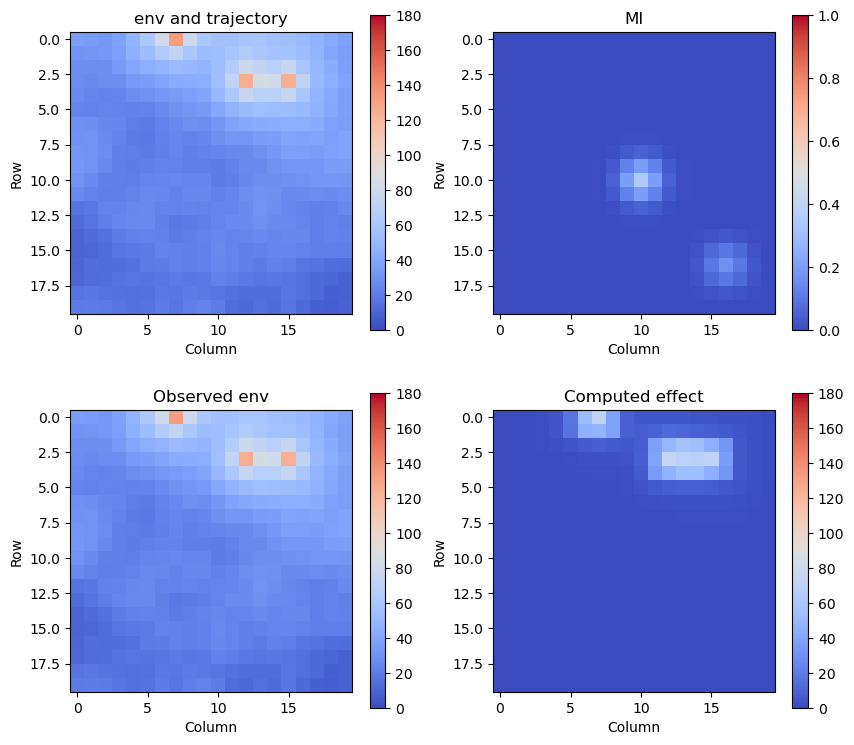

In [15]:
from pypolo2.experiments import visualizer
ani = visualizer.visual(logger)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())

In [16]:
import math
import numpy as np
Temp = 2500
k = math.pow(0.00002, 1 / 10)
k = math.pow(k, 7)
delta_e_2 = -10
accept_prob = np.exp(delta_e_2 / (k * Temp))
print(k)
print(accept_prob)

0.0005137135214831111
0.00041532843149921


In [17]:
numbers = rng.randint(0, 19, size=10)
pairs = rng.choice(numbers, size=(5, 2), replace=False)
print(pairs)

[[ 9 16]
 [ 6 10]
 [14 16]
 [18  6]
 [ 3  3]]


In [18]:
Setting.RR

array([[ 13,  11, 317],
       [  9,  14, 151],
       [ 18,  13, 253]])